# Symbolic Regression of Control Lyapunov Functions – 2D Example 2

This notebook reproduces the main numerical results for **2D Example 2**
from the paper:

> A. M. Qaragoez, R. Wisniewski, A. Lucantonio  
> *Symbolic Regression of Control Lyapunov Functions*, ....

The notebook demonstrates:
- Evaluation of a discovered symbolic CLF
- Controller synthesis via Sontag’s formula
- Comparison against LQR and baseline CLF controllers
- Visualization of trajectories, and control inputs


In [1]:
import os
import sys

# Absolute path to project root (../../ from run.py)
project_root = os.path.abspath(
    os.path.join("../../")
)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Make sure Ray subprocesses also see this
os.environ["PYTHONPATH"] = project_root + ":" + os.environ.get("PYTHONPATH", "")

In [2]:
import numpy as np

from sympy import symbols, lambdify, sin, sqrt, pprint, latex, cos, tanh
from IPython.display import display, Math

from SystemDynamicsSR import fSR, xSR, GSR, QSR, RSR

from src.SymFunctions import read_expressionCoef, substitute_paramsCoef, DeapSimplifier
from src.VVdot_Calculations import compute_v_and_v_dot
from src.SymVVdot_Calculations import compute_v_and_v_dotSR

import matplotlib.pyplot as plt

import time

import pygmo as pg
import re

import warnings

In [3]:
# run run.py to run SR-CLF algorithm!

In [4]:
from src.Functions import Dataset
# Define the numerical grid (Domain)
x1_vals = np.linspace(-2, 2, 100)
x2_vals = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals, indexing="ij")
train_data = Dataset("true_data", [x1_vals, x2_vals], None)
train_data.mesh=[X1, X2]

In [5]:
expression, fitness, parameters = read_expressionCoef("best_expression.txt") 

expression = substitute_paramsCoef(expression, parameters)

simplified_expr = DeapSimplifier(expression, should_print=True)
display(Math(latex(simplified_expr)))

Original Expression: mul(1.98751738, add(mul(x1, x1), mul(add(x2, x1), x2)))
Simplified Expression: 1.98751738*x1**2 + 1.98751738*x2*(x1 + x2)


<IPython.core.display.Math object>

In [6]:
TRQlim = None # or 2

In [7]:
# Normalization factors (use domain bounds)
s1 = np.max(np.abs(x1_vals))
s2 = np.max(np.abs(x2_vals))
scales = [s1, s2]
simplified_expr = DeapSimplifier(expression, scales=scales, should_print=True)
display(Math(latex(simplified_expr)))

Original Expression: mul(1.98751738, add(mul(x1, x1), mul(add(x2, x1), x2)))
Simplified Expression: 1.98751738*x1**2 + 1.98751738*x2*(x1 + x2)
Simplified ReScaled Expression: 0.496879345*x1**2 + 0.99375869*x2*(0.5*x1 + 0.5*x2)


<IPython.core.display.Math object>

### Notes on the CLF

- The CLF was obtained via symbolic regression and formally verified offline.


In [8]:
from src.formal_verification import a_violation_check

a_violations, _, _ = a_violation_check(simplified_expr, tol=1e-6)
print(a_violations)


ress = a_violation_check(simplified_expr, tol=1e-3)
print(ress)

1000
(0, 'unsat', 'unsat')


In [9]:
# Define symbolic variables
x1, x2 = symbols('x1 x2')
V_func = lambdify((x1, x2), simplified_expr, modules='numpy')
V_vals = V_func(X1, X2)


x_vals = [x1_vals, x2_vals]

noscales=[1, 1]

from SystemDynamics import f, G, Q, R

In [10]:
_, V_grad_mag, V_dot_vals, lambda_vals, u_vals, u_mag, a_vals, b_nvals, x_norm = compute_v_and_v_dot(
    V_vals,
    x_vals,
    train_data,
    noscales,
    f, G, Q, R,
    TRQlim,
    u_func=None
)

In [11]:
V_violations = np.count_nonzero(V_vals < 0)
print(V_violations)

Vdot_violations = np.count_nonzero(V_dot_vals > -0.001*x_norm)
print(Vdot_violations)

a_violations = np.count_nonzero((a_vals > 0) & (b_nvals[0] < 0.000001))
print(a_violations)


0
0
0


In [12]:
directory = "../Results/2DExample2"
os.makedirs(directory, exist_ok=True)

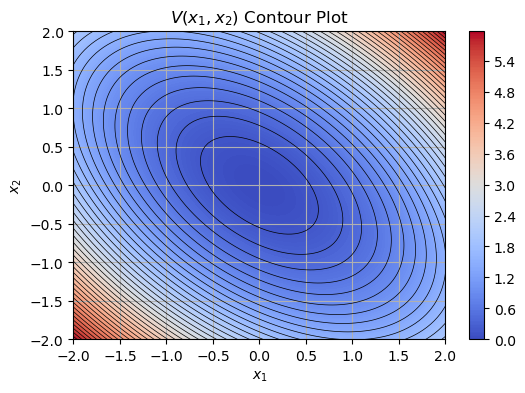

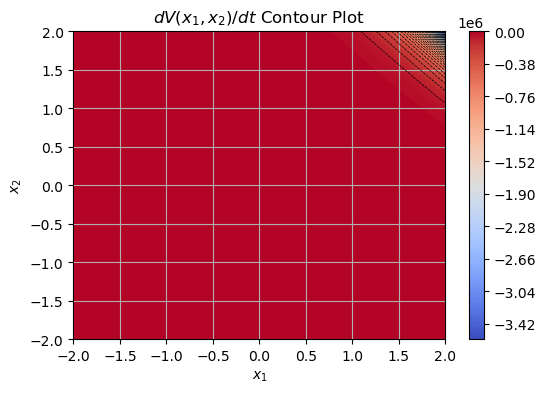

In [13]:
from src.plots import plot_contour

plot_contour(
    X1, X2, V_vals,
    r"$V(x_1, x_2)$ Contour Plot",
    "V_Nolim.png",
    directory,
    show=True,
)

plot_contour(
    X1, X2, V_dot_vals,
    r"$d V(x_1, x_2) / dt$ Contour Plot",
    "Vdot_Nolim.png",
    directory,
    show=True,
)

plot_contour(
    X1, X2, lambda_vals,
    r"$\lambda(x)$ Contour Plot",
    "lambda_Nolim.png",
    directory,
    show=False,  #just save
)

plot_contour(
    X1, X2, u_vals,
    r"$u(x)$ Contour Plot",
    "ux_Nolim.png",
    directory,
    show=False,  #just save
)

plot_contour(
    X1, X2, a_vals,
    r"$a(x)$ Contour Plot",
    None,          # no save
    directory,
    show=False,  #just save
)

plot_contour(
    X1, X2, b_nvals[2],
    r"$b(x)$ Contour Plot",
    None,          # no save
    directory,
    show=False,  #just save
)

In [14]:
V = simplified_expr
x1, x2 = symbols('x1 x2')

x_vector = xSR(x1, x2)
f_vector = fSR(x1, x2)
G_matrix = GSR(x1, x2)
Q_matrix = QSR(x1, x2)
R_matrix = RSR(x1, x2)

x_syms = [x1, x2]

V_func, V_dot_func, lambda_func, u_func, u_func2, u_mag, b_norm_squared, b1, a = compute_v_and_v_dotSR(
    V, fSR, GSR, QSR, RSR, x_syms, None
)

print(u_func)
u_func

-(x2*(0.99375869*x1 + 0.496879345*x2) + (0.496879345*x1 + 0.99375869*x2)*(0.5*x2*exp(4*x1 + 3*x2) - (x1 + 0.5*x2)*exp(x2)) + sqrt((0.496879345*x1 + 0.99375869*x2)**2*(x1**2 + x2**2)*exp(4*x1 + 4*x2) + (x2*(0.99375869*x1 + 0.496879345*x2) + (0.496879345*x1 + 0.99375869*x2)*(0.5*x2*exp(4*x1 + 3*x2) - (x1 + 0.5*x2)*exp(x2)))**2))*exp(-4*x1 - 4*x2)*exp(2*x1 + 2*x2)/(0.496879345*x1 + 0.99375869*x2)


-(x2*(0.99375869*x1 + 0.496879345*x2) + (0.496879345*x1 + 0.99375869*x2)*(0.5*x2*exp(4*x1 + 3*x2) - (x1 + 0.5*x2)*exp(x2)) + sqrt((0.496879345*x1 + 0.99375869*x2)**2*(x1**2 + x2**2)*exp(4*x1 + 4*x2) + (x2*(0.99375869*x1 + 0.496879345*x2) + (0.496879345*x1 + 0.99375869*x2)*(0.5*x2*exp(4*x1 + 3*x2) - (x1 + 0.5*x2)*exp(x2)))**2))*exp(-4*x1 - 4*x2)*exp(2*x1 + 2*x2)/(0.496879345*x1 + 0.99375869*x2)

In [15]:
import sympy as sp
from sympy import simplify
from pathlib import Path

# Define symbols
x1, x2 = sp.symbols('x1 x2')

# Dictionary of names and expressions
exprs = {
    "V": (r"V(x)", V_func),
    "V_dot": (r"\dot{V}(x)", V_dot_func),
    "lambda": (r"\lambda(x)", lambda_func),
    "b1": (r"b_1(x)", b1)
}

# Write each expression to its own file
for filename, (symbol_name, expr) in exprs.items():
    expr = simplify(expr)
    expr_rounded = expr.xreplace({n: round(n, 3) for n in expr.atoms(sp.Number)})
    latex_expr = sp.latex(expr_rounded)

    with open(Path(directory) / f"{filename}.tex", "w") as f:
        f.write(f"\\begin{{dmath}}\n    {symbol_name} = {latex_expr}\n\\end{{dmath}}\n")

print(f"Expressions written to: {Path(directory)}")

Expressions written to: ../Results/2DExample2


Is eq completely inside ineq? -> True
Fraction of eq points outside ineq: nan


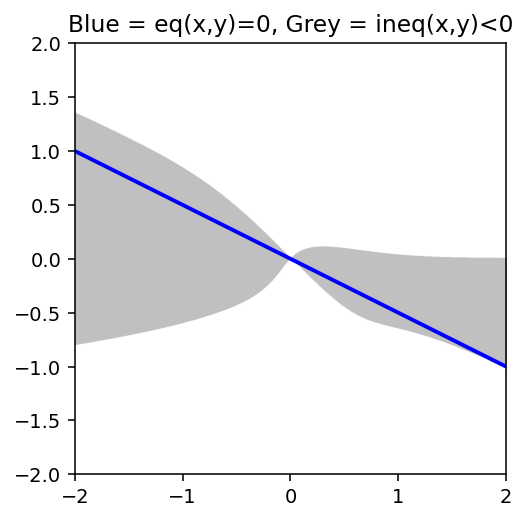

In [16]:
from src.plots import check_eq_inside_ineq_and_plot

warnings.filterwarnings("ignore")
all_inside, fraction_inside = check_eq_inside_ineq_and_plot(
    x1=x1,
    x2=x2,
    eq_sym=b_norm_squared[2],
    ineq_sym=a,
    xmin=-2, xmax=2, ymin=-2, ymax=2,
    res=1300,
    tol=1e-6,
    ineq_thresh=1e-5,
    figsize=(4, 4),
    dpi=140,
    show=True,
)

## -*- Time-domain simulations and State-space trajectories


In [17]:
from sympy import symbols, Function, Matrix, Eq, dsolve
from SystemDynamics import f, G, Q, R
from src.NumSol import NumSol
import matplotlib.pyplot as plt

In [18]:
x1, x2 = symbols('x1 x2')

from sympy import symbols, lambdify, diff, Matrix, sin, cos, exp, log, sqrt, tanh

T = 20
#x1_0, x2_0 
x0 = [1, 0]

In [19]:
u_func_LQR = -0.414213562373094*x1 - 1.35219344945396*x2
t_vals_L, x_vals_L = NumSol(u_func_LQR, T, x0, fSR, GSR, None, TRQlim)

u_func_FLF = -0.5 * x2 * exp(2* x1 + x2)
t_vals_E, x_vals_E = NumSol(u_func_FLF, T, x0, fSR, GSR, None, TRQlim)

u_func_CLF = u_func * 1
t_vals_C, x_vals_C = NumSol(u_func_CLF, T, x0, fSR, GSR, b_norm_squared[0], TRQlim)


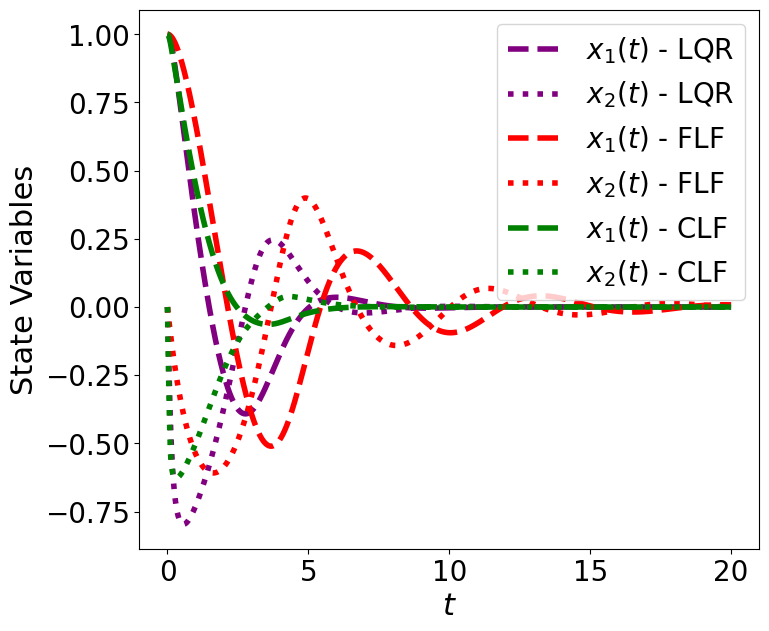

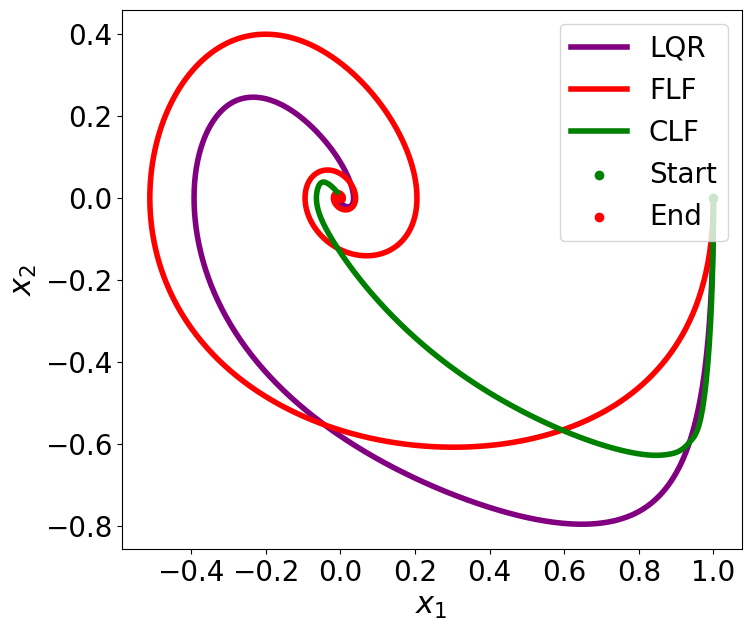

In [20]:
from src.plots import plot_states_and_path

xylabel_font_size=22
axis_font_size=20
legend_font_size=20
dpi=300

plot_states_and_path(
    directory=directory,
    filename_states="StatesoverTime_Nolim.png",
    filename_path="Path_Nolim.png",
    x0=x0,
    xylabel_font_size=22,
    axis_font_size=20,
    legend_font_size=20,
    dpi=300,
    show=True,
    n_tick=5,
    time_series=[
        {"t": t_vals_L, "x": x_vals_L, "label1": r"$x_1(t)$ - LQR", "label2": r"$x_2(t)$ - LQR",
         "color": "purple", "ls1": "--", "ls2": ":", "lw": 4.0},
        {"t": t_vals_E, "x": x_vals_E, "label1": r"$x_1(t)$ - FLF", "label2": r"$x_2(t)$ - FLF",
         "color": "red", "ls1": "--", "ls2": ":", "lw": 4.0},
        {"t": t_vals_C, "x": x_vals_C, "label1": r"$x_1(t)$ - CLF", "label2": r"$x_2(t)$ - CLF",
         "color": "green", "ls1": "--", "ls2": ":", "lw": 4.0},
    ],
    path_series=[
        {"x": x_vals_L, "label": "LQR", "color": "purple", "lw": 4.0},
        {"x": x_vals_E, "label": "FLF", "color": "red", "lw": 4.0},
        {"x": x_vals_C, "label": "CLF", "color": "green", "lw": 4.0},
    ],
)


In [21]:
from src.CostFunction import calculate_cost

# Calculate the cost
cost_LQR, cost_LQR1, cost_LQR2, u_val_LQR = calculate_cost(t_vals_L, x_vals_L, u_func_LQR, GSR, Q, R, None, TRQlim, 0)
print("Total cost for LQR:", cost_LQR)

cost_FLF, cost_FLF1, cost_FLF2, u_val_FLF = calculate_cost(t_vals_E, x_vals_E, u_func_FLF, GSR, Q, R, None, TRQlim, 0)
print("Total cost for FLF:", cost_FLF)

cost_CLF, cost_CLF1, cost_CLF2, u_val_CLF = calculate_cost(t_vals_C, x_vals_C, u_func_CLF, GSR, Q, R, b_norm_squared[0], TRQlim, 0)
print("Total cost for CLF:", cost_CLF)

Total cost for LQR: 3.027004830671387
Total cost for FLF: 3.111954484720275
Total cost for CLF: 2.383285598090595


In [22]:
# Prepare values
rows = [
    ("LQR", round(cost_LQR1, 3), round(cost_LQR2, 3), round(cost_LQR, 3)),
    ("FLF", round(cost_FLF1, 3), round(cost_FLF2, 3), round(cost_FLF, 3)),
    ("CLF", round(cost_CLF1, 3), round(cost_CLF2, 3), round(cost_CLF, 3)),
]

# Output path
tex_file_path = os.path.join(directory, "table_costs.tex")

# Write LaTeX tabular
with open(tex_file_path, 'w') as f:
    f.write(r"""\begin{tabular}{lccc}
        \toprule
        Method & Cost 1 & Cost 2 & Total \\
        \midrule
""")
    for method, c1, c2, total in rows:
        f.write(f"        {method} & {c1} & {c2} & {total} \\\\\n")
    f.write(r"""        \bottomrule
    \end{tabular}
""")

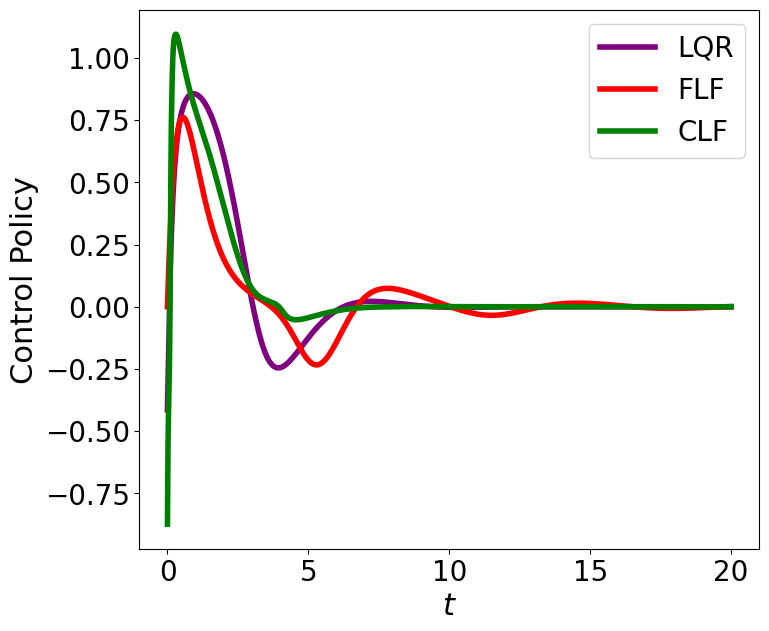

In [23]:
from src.plots import plot_u_over_time

plot_u_over_time(
    directory=directory,
    filename="uoverTime_Nolim.png",
    xylabel_font_size=xylabel_font_size,
    axis_font_size=axis_font_size,
    legend_font_size=legend_font_size,
    dpi=dpi,
    show=True,
    n_tick=5,
    series=[
        {"t": t_vals_L, "u": u_val_LQR, "label": "LQR", "color": "purple", "lw": 4},
        {"t": t_vals_E, "u": u_val_FLF, "label": "FLF", "color": "red", "lw": 4},
        {"t": t_vals_C, "u": u_val_CLF, "label": "CLF", "color": "green", "lw": 4},
    ],
)


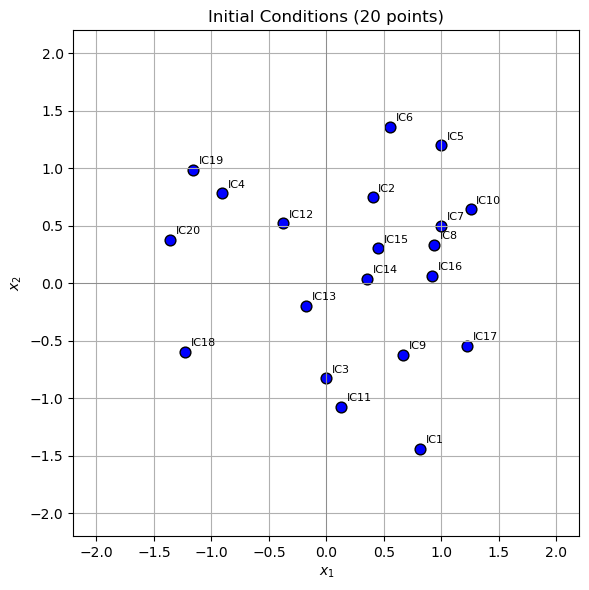

In [24]:
import numpy as np

# Initial Conditions and Horizon
# ICs = np.array([
#     [ 0.5,  0.0],
#     [ 1.0,  1.0],
#     [ 0.0,  0.5],
#     [-1.0,  1.0],
#     [-0.5,  0.0],
#     [-1.0, -1.0],
#     [ 0.0, -0.5],
#     [ 1.0, -1.0],
#     [ 2.0,  0.0],
#     [-2.0,  0.0],
#     [ 0.0,  2.0],
#     [ 0.0, -2.0],
#     [ 1.5,  1.5],
#     [-1.5,  1.5],
#     [ 1.5, -1.5],
#     [-1.5, -1.5],
#     [ 1.0,  0.0],
#     [-1.0,  0.0],
#     [ 0.0,  1.0],
#     [ 0.0, -1.0]
# ])

# Generate 20 random 2D initial conditions in the range [-2, 2]
np.random.seed(10)
num_ICs = 20
x_indices = np.arange(1, num_ICs + 1)
ICs = np.random.uniform(-1.5, 1.5, (num_ICs, 2))  # shape (20, 2)
ICs[4]=[1, 1.2]
ICs[6]=[1, 0.5]

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(ICs[:, 0], ICs[:, 1], c='blue', s=60, edgecolors='black')
for i, (x, y) in enumerate(ICs):
    plt.text(x + 0.05, y + 0.05, f'IC{i+1}', fontsize=8)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(True)
plt.title("Initial Conditions (20 points)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
plt.gca().set_aspect('equal')
plt.tight_layout()
save_path = os.path.join(directory, "RandomICs.png")
plt.savefig(save_path, dpi=500, bbox_inches='tight')
plt.show()

T = 6

# Storage for Costs
costs_LQR = []
costs_LQR1 = []
costs_LQR2 = []

costs_FLF = []
costs_FLF1 = []
costs_FLF2 = []

costs_CLF = []
costs_CLF1 = []
costs_CLF2 = []

for x0 in ICs:
    warnings.filterwarnings("ignore")
    t_vals_L, x_vals_L = NumSol(u_func_LQR, T, x0, fSR, GSR, None, TRQlim)
    t_vals_F, x_vals_F = NumSol(u_func_FLF, T, x0, fSR, GSR, None, TRQlim)
    t_vals_C, x_vals_C = NumSol(u_func_CLF, T, x0, fSR, GSR, b_norm_squared[0], TRQlim)

    # Condition Check Function
    def check_invalid(x_vals):
        # Convert to NumPy array with shape (timesteps, 2)
        x_vals = np.array(x_vals).T  # Ensure shape is (N, 2)
        return (x_vals[-1, 0]**2 + x_vals[-1, 1]**2) > 0.05

    # Apply Condition to Each Case
    if check_invalid(x_vals_L):
        cost_LQR = 30 # or np.nan
    else:
        cost_LQR, cost_LQR1, cost_LQR2, _ = calculate_cost(t_vals_L, x_vals_L, u_func_LQR, GSR, Q, R, None, TRQlim, 0)

    if check_invalid(x_vals_E):
        cost_FLF = 30 # or np.nan
    else:
        cost_FLF, cost_FLF1, cost_FLF2, _ = calculate_cost(t_vals_F, x_vals_F, u_func_FLF, GSR, Q, R, None, TRQlim, 0)

    if check_invalid(x_vals_C):
        cost_CLF = 30 # or np.nan
    else:
        cost_CLF, cost_CLF1, cost_CLF2, _ = calculate_cost(t_vals_C, x_vals_C, u_func_CLF, GSR, Q, R, b_norm_squared[0], TRQlim, 0)

    costs_LQR.append(cost_LQR)
    costs_LQR1.append(cost_LQR1)
    costs_LQR2.append(cost_LQR2)
    
    costs_FLF.append(cost_FLF)
    costs_FLF1.append(cost_FLF1)
    costs_FLF2.append(cost_FLF2)
    
    costs_CLF.append(cost_CLF)
    costs_CLF1.append(cost_CLF1)
    costs_CLF2.append(cost_CLF2)

# Convert to NumPy for easier calculations
costs_LQR = np.array(costs_LQR)
costs_LQR1 = np.array(costs_LQR1)
costs_LQR2 = np.array(costs_LQR2)

costs_FLF = np.array(costs_FLF)
costs_FLF1 = np.array(costs_FLF1)
costs_FLF2 = np.array(costs_FLF2)

costs_CLF = np.array(costs_CLF)
costs_CLF1 = np.array(costs_CLF1)
costs_CLF2 = np.array(costs_CLF2)

# Count how many times each method has the lowest cost
wins_LQR = np.sum((costs_LQR < costs_FLF) & (costs_LQR < costs_CLF))
wins_FLF  = np.sum((costs_FLF < costs_LQR) & (costs_FLF < costs_CLF))
wins_CLF = np.sum((costs_CLF < costs_LQR) & (costs_CLF < costs_FLF))


# Compute Mean and Std Dev
mean_LQR, std_LQR = np.mean(costs_LQR), np.std(costs_LQR)
mean_LQR1, std_LQR1 = np.mean(costs_LQR1), np.std(costs_LQR1)
mean_LQR2, std_LQR2 = np.mean(costs_LQR2), np.std(costs_LQR2)

mean_FLF, std_FLF = np.mean(costs_FLF), np.std(costs_FLF)
mean_FLF1, std_FLF1 = np.mean(costs_FLF1), np.std(costs_FLF1)
mean_FLF2, std_FLF2 = np.mean(costs_FLF2), np.std(costs_FLF2)

mean_CLF, std_CLF = np.mean(costs_CLF), np.std(costs_CLF)
mean_CLF1, std_CLF1 = np.mean(costs_CLF1), np.std(costs_CLF1)
mean_CLF2, std_CLF2 = np.mean(costs_CLF2), np.std(costs_CLF2)

# Prepare Rows for LaTeX
rows = []
for idx, x0 in enumerate(ICs):
    ic_str = f"IC{idx+1} ({x0[0]:.2f}, {x0[1]:.2f})"
    rows.append((ic_str, f"{costs_LQR[idx]:.3f}", f"{costs_FLF[idx]:.3f}", f"{costs_CLF[idx]:.3f}"))

rows.append(("Average", f"{mean_LQR:.3f}", f"{mean_FLF:.3f}", f"{mean_CLF:.3f}"))
rows.append(("Std Dev", f"{std_LQR:.3f}", f"{std_FLF:.3f}", f"{std_CLF:.3f}"))

# Output Path
tex_file_path = os.path.join(directory, "bench_table_costs.tex")

# Write LaTeX Table
with open(tex_file_path, 'w') as f:
    f.write(r"""\begin{tabular}{lccc}
\toprule
Initial Condition & LQR & FLF & CLF \\
\midrule
""")
    for method, c1, c2, c3 in rows:
        f.write(f"{method} & {c1} & {c2} & {c3} \\\\\n")
    f.write(r"""\bottomrule
\end{tabular}
""")

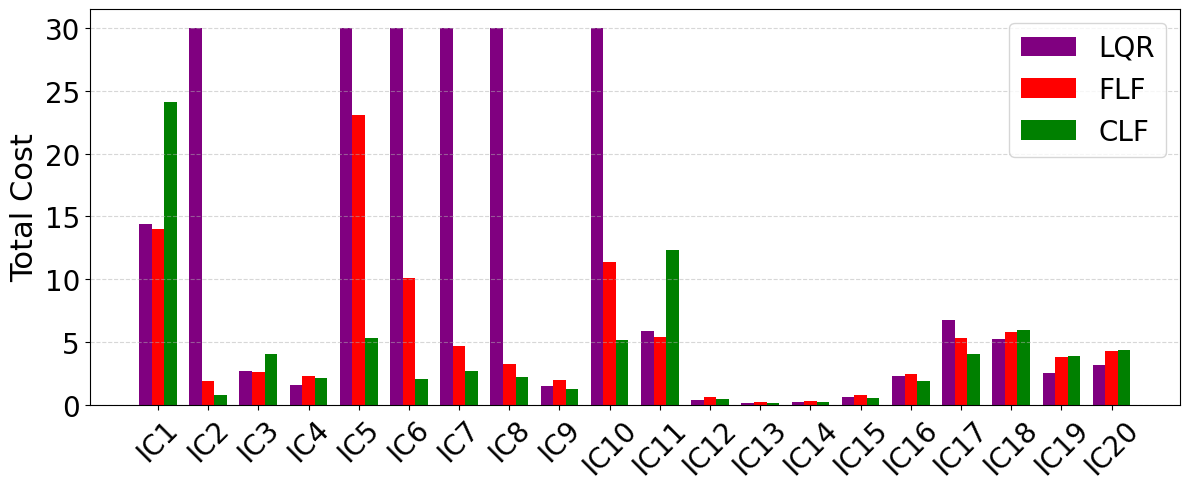

In [25]:
x = np.arange(num_ICs)

bar_width = 0.25

plt.figure(figsize=(12, 5))

# Plot bars side-by-side
plt.bar(x - bar_width, costs_LQR, width=bar_width, label='LQR', color='purple')
plt.bar(x, costs_FLF, width=bar_width, label='FLF', color='red')
plt.bar(x + bar_width, costs_CLF, width=bar_width, label='CLF', color='green')

# Formatting
plt.xticks(x, [f'IC{i+1}' for i in x], rotation=45, fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)
plt.ylabel('Total Cost', fontsize=xylabel_font_size)
# plt.title('Control Cost per Initial Condition (Grouped by Method)')
plt.legend(fontsize=legend_font_size)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
save_path = os.path.join(directory, "Cost_Hist.png")
plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
plt.show()